In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Load data, add column names for data exploration purposes
df_cancer = pd.read_csv("/Users/amandakinnischtzke/Dropbox/amanda/insightdatascience/18B/Data-Challenge-1/breast-cancer-wisconsin.csv", header=-1)
column_names = ['Sample id','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size',
                     'Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
df_cancer.columns = column_names
df_cancer.set_index(keys=['Sample id'],drop=True,inplace=True)
print("Shape of cancer dataset: ", str(df_cancer.shape))
print("Shape of cancer dataset, if dropped any rows with NaNs: ", str(df_cancer.dropna(axis=0).shape))

df_cancer.head()

Shape of cancer dataset:  (699, 10)
Shape of cancer dataset, if dropped any rows with NaNs:  (699, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Sample id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df_cancer.dtypes

Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [4]:
# Column 'bare nuclei' is an object for some reason, check if some values are not numeric (already checked for nans).
print("Number of non-numeric values: ",str(df_cancer.shape[0] - df_cancer['Bare Nuclei'].str.isnumeric().sum()))
print(df_cancer.loc[df_cancer['Bare Nuclei'].str.isnumeric() == False]['Bare Nuclei'])

Number of non-numeric values:  16
Sample id
1057013    ?
1096800    ?
1183246    ?
1184840    ?
1193683    ?
1197510    ?
1241232    ?
169356     ?
432809     ?
563649     ?
606140     ?
61634      ?
704168     ?
733639     ?
1238464    ?
1057067    ?
Name: Bare Nuclei, dtype: object


In [5]:
# For now we'll drop these rows as there aren't very many. May reconsider this later.
df_cancer.drop(labels=df_cancer[df_cancer['Bare Nuclei'] == '?'].index, axis=0, inplace=True)
print("New shape of cancer dataset: ", str(df_cancer.shape))

# Now convert this column to integers
df_cancer['Bare Nuclei'] = df_cancer['Bare Nuclei'].astype(int) #column was object type, converted to int liek rest of columns
df_cancer.dtypes

New shape of cancer dataset:  (682, 10)


Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

In [6]:
# Look at how many classes there are that we'll be predicting
print(df_cancer.groupby('Class')['Clump Thickness'].count())

Class
2    443
4    239
Name: Clump Thickness, dtype: int64


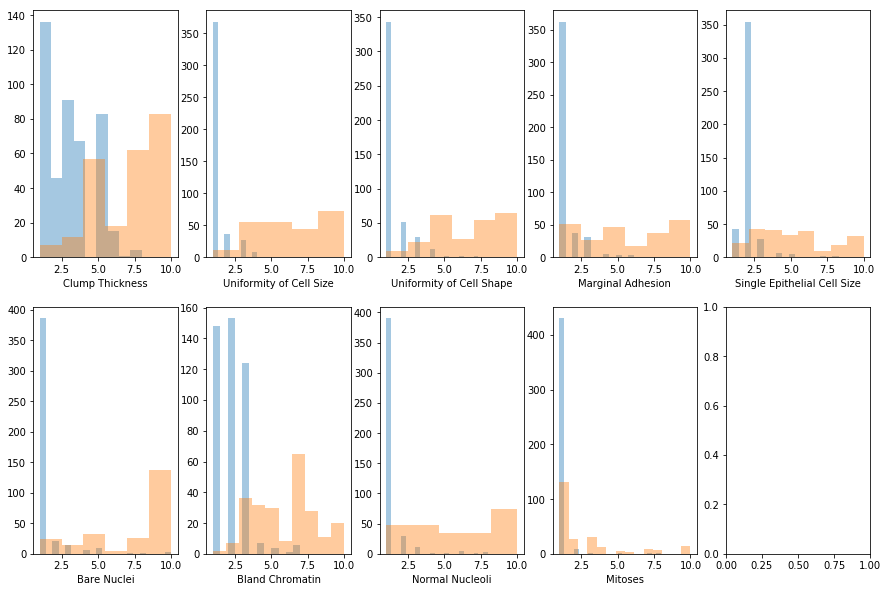

In [7]:
# Let's look at the distibution of each feature, and separated by class.
fig, ax = plt.subplots(2,5,figsize=(15,10))

for col in range(df_cancer.shape[1]-1):

    d_class2 = df_cancer.loc[df_cancer['Class'] == 2][df_cancer.columns[col]]
    d_class4 = df_cancer.loc[df_cancer['Class'] == 4][df_cancer.columns[col]]
    
    ax_row = int(np.floor(col/5))
    ax_col = col % 5
    sns.distplot(d_class2, kde=False, rug=False, ax=ax[ax_row, ax_col])
    sns.distplot(d_class4, kde=False, rug=False, ax=ax[ax_row, ax_col])


Looks like many of the features are very segregated for the difference classes. Seems like a model should be able to predict classes pretty well.

Given that this is a classifier problem, we'll start by creating a few different classifier models and see how they perform. The specific performance and errors for each model may give additional insights into the data.

In [17]:
# Let's try a few different classifier models, and see how each performs

# First, split dataset into features and labels
y = np.array(df_cancer['Class'])
X = np.array(df_cancer.drop(labels='Class', axis=1))
X_list = df_cancer.columns.drop(labels='Class')

print("Labels shape: ", str(y.shape))
print("Features shape: ", str(X.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training set size: ", str(X_train.shape))
print("Test set size: ", str(X_test.shape))

Labels shape:  (682,)
Features shape:  (682, 9)
Training set size:  (545, 9)
Test set size:  (137, 9)


In [18]:
# Create classifiers and test each on the data 
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier(n_estimators=100)

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'), 
                  (rfc, 'Random Forest')]:
    print(name)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Reminder: class 2 -> benign, class 4 -> malignant
    pred_prob = clf.predict_proba(X_test)
    results = pd.DataFrame({'actual': y_test,
                        'predicted': pred,
                        'pred prob_class2': pred_prob[:, 0],
                        'pred prob_class4': pred_prob[:, 1]})
    
    print("True negatives: ", str(tn), "True positives: ", str(tp))
    print("False negatives: ", str(fn), "False positives: ", str(fp))
    score = accuracy_score(y_test, pred)
    print("Accuracy: ", "{0:0.2f}".format(100*score), "%")
    print(" ")
    


Logistic
True negatives:  88 True positives:  40
False negatives:  5 False positives:  4
Accuracy:  93.43 %
 
Naive Bayes
True negatives:  85 True positives:  43
False negatives:  2 False positives:  7
Accuracy:  93.43 %
 
Random Forest
True negatives:  89 True positives:  43
False negatives:  2 False positives:  3
Accuracy:  96.35 %
 


On first pass, each model performs pretty well, each ~95% accuracy. But for this dataset, where we're predicting a cancer diagnosis, **false negatives are much worse than false positives** (i.e. result in an instance of cancer going undiagnosed). In this sense, the Naive Bayes would probably be the best choice, as it has the lowest number of false negatives.

However, we should explore further to determine if we can adjust the model predictions to minimize false negatives even further (even if it means increasing false positives).

First thing to try is changing the classification threshold, which by default is equal to 0.5. Decreasing it will cause fewer cases to be classified in class 4 (benign), therefore potentially increasing the false positives but hopefully decreasing the false negatives.


In [20]:
# Let's try changing the classification threshold on each classifier model

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier(n_estimators=100)

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'), 
                  (rfc, 'Random Forest')]:
    print(name)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
 
    # Reminder: class 2 -> benign, class 4 -> malignant
    pred_prob = clf.predict_proba(X_test)
    results = pd.DataFrame({'actual': y_test,
                        'predicted': pred,
                        'pred prob_class2': pred_prob[:, 0],
                        'pred prob_class4': pred_prob[:, 1]})
    
    # Am manually changing the classification threshold from 0.5 to 0.3 for categorizing in class 4.
    ind = results.index[results['pred prob_class4'] >= 0.3] # indices of all cases with prediction prob of >=0.3 
    results['predicted 2'] = 2
    results.loc[ind,('predicted 2')] = 4 

    # Now calculating the confusion matrix again
    tn, fp, fn, tp = confusion_matrix(y_test, np.array(results['predicted 2'])).ravel()
    print("True negatives: ", str(tn), "True positives: ", str(tp))
    print("False negatives: ", str(fn), "False positives: ", str(fp))
    score = accuracy_score(y_test, pred)
    print("Accuracy: ", "{0:0.2f}".format(100*score), "%")
    print(" ")
  


Logistic
True negatives:  87 True positives:  41
False negatives:  4 False positives:  5
Accuracy:  93.43 %
 
Naive Bayes
True negatives:  85 True positives:  43
False negatives:  2 False positives:  7
Accuracy:  93.43 %
 
Random Forest
True negatives:  88 True positives:  45
False negatives:  0 False positives:  4
Accuracy:  95.62 %
 


We have successfully reduced the number of false negatives. Therefore this seems to be a successful strategy for this problem. We could keep exploring ]to find the optimal threshold, such as with a ROC curve. In this case 0.3 was successful but isn't necessarily always the best choice.

Additional techniques could be tried (with more time). For example, there was a class imbalance between benign/malignant, with about half as many malignant samples as benign. We could try some resampling techniques to fix this and perhaps that would improve the classification. Also, further data exploration on the mis-classified samples may yield insight about whether specific features were causing incorrection classification, which could yield further directions to try in building a robust model.